In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf
from tensorflow import keras

tf.get_logger().setLevel('ERROR')
print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.10.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from utils.preprocessing import preprocess

raw_ds = preprocess('word2vec')
dim = raw_ds['model'].vector_size
mat = raw_ds['mat']

Total number of news: 30339
Maximum number of news for each group in training set: 64
Minimum number of news for each group in training set: 3
Maximum number of news for each group in test set: 26
Minimum number of news for each group in test set: 3
Maximum number of times a news appears in training set: 22
Minimum number of times a news appears in training set: 0
Maximum number of times a news appears in test set: 11
Minimum number of times a news appears in test set: 0
Loading Word2Vec model...


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Stanl\AppData\Local\Temp\jieba.cache


Word2vec model loaded.


Loading model cost 0.682 seconds.
Prefix dict has been built successfully.


In [3]:
raw_train = np.array(raw_ds['train'], dtype=list)
raw_valid = np.array(raw_ds['valid'], dtype=list)
raw_test = np.array(raw_ds['test'], dtype=list)
train_label = raw_train[:, 1]
valid_label = raw_valid[:, 1]
train_label.shape, valid_label.shape

((7158,), (796,))

In [4]:
titleK, contentK = 1, 4
maxlen = 64
train_pad = keras.preprocessing.sequence.pad_sequences(raw_train[:, 0], maxlen=maxlen, padding='post').astype('<U8')
valid_pad = keras.preprocessing.sequence.pad_sequences(raw_valid[:, 0], maxlen=maxlen, padding='post').astype('<U8')
test_pad = keras.preprocessing.sequence.pad_sequences(raw_ds['test'], maxlen=maxlen, padding='post').astype('<U8')
train_pad.shape, valid_pad.shape, test_pad.shape

((7158, 64), (796, 64), (3000, 64))

In [5]:
def reshapeData(pad, mat, dim, maxlen, K):
    data = np.empty((pad.shape[0], dim, maxlen, K))
    for i in range(pad.shape[0]):
        for j in range(maxlen):
            data[i, :, j] = mat[pad[i, j]].T
    return data.reshape((pad.shape[0], dim, -1))

train_data = reshapeData(train_pad, mat, dim, maxlen, titleK+contentK)
valid_data = reshapeData(valid_pad, mat, dim, maxlen, titleK+contentK)
test_data = reshapeData(test_pad, mat, dim, maxlen, titleK+contentK)
train_data.shape, valid_data.shape, test_data.shape

((7158, 100, 320), (796, 100, 320), (3000, 100, 320))

In [6]:
train_data = tf.data.Dataset.from_tensor_slices(train_data.astype(np.float32))
valid_data = tf.data.Dataset.from_tensor_slices(valid_data.astype(np.float32))
test_data = tf.data.Dataset.from_tensor_slices(test_data.astype(np.float32))

train_label = tf.data.Dataset.from_tensor_slices(train_label.astype(np.int32))
valid_label = tf.data.Dataset.from_tensor_slices(valid_label.astype(np.int32))

train_ds = tf.data.Dataset.zip((train_data, train_label))
valid_ds = tf.data.Dataset.zip((valid_data, valid_label))

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 512
BATCH_SIZE = 32

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
test_ds = test_data.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

In [8]:
from model import w2v

loss = keras.losses.BinaryCrossentropy(from_logits=False)
metrics = [keras.metrics.BinaryAccuracy(),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc')]
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-4)
callbacks = tf.keras.callbacks.TensorBoard(log_dir='logs')
epochs = 5
maxlenK = maxlen*(titleK+contentK)

model = w2v.build_model((dim, maxlenK), optimizer, loss, metrics)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100, 256)         459776    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [9]:
history = model.fit(train_ds, validation_data=valid_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/5
224/224 [==============================] - 20s 42ms/step - loss: 0.7641 - binary_accuracy: 0.5293 - precision: 0.6675 - recall: 0.5155 - auc: 0.5604 - val_loss: 0.7200 - val_binary_accuracy: 0.6244 - val_precision: 0.6255 - val_recall: 0.9899 - val_auc: 0.6219
Epoch 2/5
224/224 [==============================] - 8s 34ms/step - loss: 0.6945 - binary_accuracy: 0.5993 - precision: 0.7088 - recall: 0.6262 - auc: 0.6345 - val_loss: 0.6893 - val_binary_accuracy: 0.6219 - val_precision: 0.6281 - val_recall: 0.9637 - val_auc: 0.6366
Epoch 3/5
224/224 [==============================] - 8s 34ms/step - loss: 0.6668 - binary_accuracy: 0.6298 - precision: 0.7112 - recall: 0.7021 - auc: 0.6681 - val_loss: 0.6770 - val_binary_accuracy: 0.6219 - val_precision: 0.6550 - val_recall: 0.8306 - val_auc: 0.6376
Epoch 4/5
224/224 [==============================] - 8s 34ms/step - loss: 0.6470 - binary_accuracy: 0.6551 - precision: 0.7133 - recall: 0.7637 - auc: 0.6927 - val_loss: 0.6782 - val_binary

dict_keys(['loss', 'binary_accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_binary_accuracy', 'val_precision', 'val_recall', 'val_auc'])


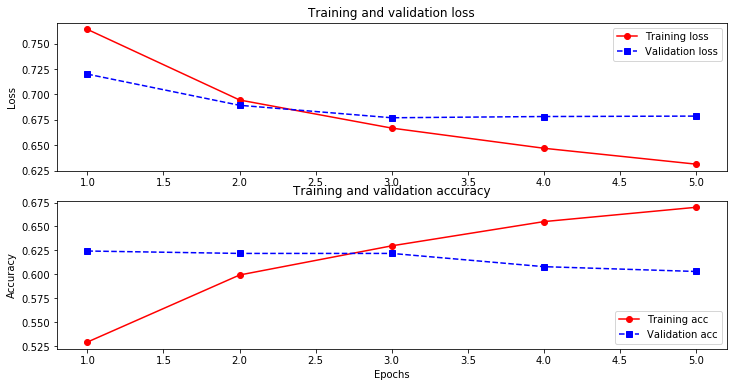

In [10]:
from utils.visualization import plot_history, plot_structure

plot_structure(model, 'word2vec.png')
plot_history(history.history)

In [11]:
from utils.prediction import predict

predict(model, test_ds, 'w2v_prediction.txt')

94/94 [==============================] - 3s 12ms/step


array([[0.52117753],
       [0.6525718 ],
       [0.52554744],
       ...,
       [0.5271621 ],
       [0.67948383],
       [0.559614  ]], dtype=float32)